In [8]:
from random import random
from math import exp,sqrt
from numba import njit, prange
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt

#@lru_cache(maxsize=4)
@njit
def f(x): 
    if x>0.33:
        return exp(x) + x-0.33 - 0.67**2/2
    return exp(x) - 0.67**2/2
    
@njit(fastmath=True)
def trapezium(n,a,b):
    dx = (b-a)/n
    x,sol = 0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        x = xx
    return sol*dx

@njit(fastmath=True)
def MCtrapezium(n,a,b):
    dx = (b-a)/n
    x,sol,solMC,solMC2 = 0,0,0,0
    for _ in range(n):
        xx = x + dx
        sol += (f(x)+f(xx))/2 # inefficient
        l = 10 # russian roulette rate 
        if random()*l<1:
            U = x + random()*(xx-x) # \sim Uniform(x,xx)
            tmp= l*(f(U)-f(x)-(U-x)*(f(xx)-f(x))/dx)
            solMC += tmp
            solMC2 += tmp**2
        x = xx
    return dx*(sol+solMC), sqrt(solMC2-solMC**2)*dx

def exact(a,b): return exp(b)-exp(a) 
MCtrapezium(100,0,1)

(1.5592315247454636, nan)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3532\3851080029.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
C:\Users\Admin\AppData\Local\Temp\ipykernel_3532\3851080029.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")


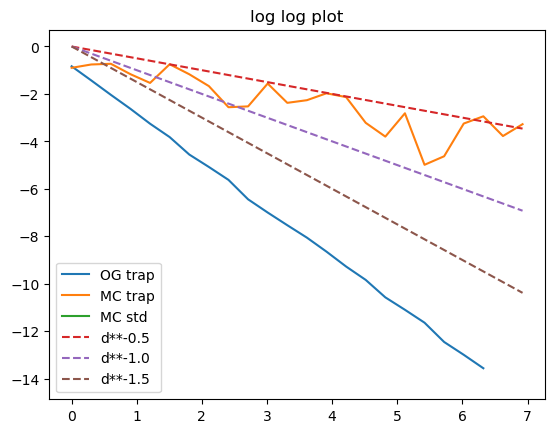

In [9]:

def MCtrap_llplot():
    a,b = 0,1
    DTS = np.power(2,np.array(range(24)))
    errors = np.array([(abs(trapezium(n,a,b)-exact(a,b)))/(exact(a,b)) for n in DTS])
    MCerrors,MCsig = [],[]
    for n in DTS:
        sol,sig = MCtrapezium(n,a,b)
        MCerrors.append((abs(sol-exact(a,b)))/(exact(a,b)))
        MCsig.append(sig)
    plt.plot(np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = "OG trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCerrors)/np.log(10), label = "MC trap")
    plt.plot(np.log(DTS)/np.log(10),np.log(MCsig)/np.log(10), label = "MC std")
    dgs = np.arange(0.5,2,0.5)
    for l in dgs:
        ref = np.array([pow(1/d,l) for d in DTS])
        plt.plot(np.log(DTS)/np.log(10),np.log(ref)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

MCtrap_llplot()